# Importing all required things

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
!pip install -q imbalanced-learn xgboost
# Force Upgrade XGboost
!pip install -U xgboost --quiet

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,roc_auc_score,precision_recall_curve,roc_curve,average_precision_score

# Data preprocessing

In [ ]:
# first i set option to display all columns
pd.set_option('display.max_columns',None)

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/data.csv")

In [ ]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

In [ ]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
# for less memory usage and faster training i converted dtype from float64 to float32 and int64 to int8
for col in df.select_dtypes(include="float64").columns:
    df[col]=df[col].astype("float32")
for col in df.select_dtypes(include="int64").columns:
    df[col]=df[col].astype("int8")

In [ ]:
#checking for null values in any column
df.isnull().sum().max()

0

In [ ]:
# checking for duplicated rows
df.duplicated().sum()

np.int64(0)

In [ ]:
# if any column contain only single value
df.columns[df.nunique()==1]

Index([' Net Income Flag'], dtype='object')

In [ ]:
# deleting single-valued column bcz it will not contribute anything to model prediction
del df[" Net Income Flag"]

In [ ]:
# minimun and maximum values of every column
df.describe().T[['min','max']]

,min,max
Bankrupt?,0.0,1.0
ROA(C) before interest and depreciation before interest,0.0,1.0
ROA(A) before interest and % after tax,0.0,1.0
ROA(B) before interest and depreciation after tax,0.0,1.0
Operating Gross Margin,0.0,1.0
...,...,...
Net Income to Stockholder's Equity,0.0,1.0
Liability to Equity,0.0,1.0
Degree of Financial Leverage (DFL),0.0,1.0
Interest Coverage Ratio (Interest expense to EBIT),0.0,1.0


In [ ]:
# separating output labels from features
y=df["Bankrupt?"]
df=df.drop("Bankrupt?",axis=1)

## Identifying and Handling Outliers

#### Outliers are very big problem in this dataset. Some of columns contain values in the order from e-4 to e+9 which will definitely affect model performance  

### IQR method

In [ ]:
# Compute IQR(InterQuantile Range)
Q1=df.quantile(0.25) # 25% data is below this value
Q3=df.quantile(0.75) # 75% data is below this value
IQR=Q3-Q1            # spread of middle 50% of data

Lower_bound= Q1 - 1.5*IQR
Upper_bound= Q3 + 1.5*IQR
# Boolean mask of outliers
is_outlier=((df<Lower_bound) | (df>Upper_bound)).any(axis=1)

In [ ]:
is_outlier.sum()
# since iqr method identifies most of rows as outlier this is not good method here

np.int64(6361)

### taking log of cols which contain very extreme values

In [ ]:
cols_to_log=[col for col in df.columns if df[col].max() >1e6]

In [ ]:
# taking log(1+x) so that very small values does not get converted to -infinity
df[cols_to_log]=df[cols_to_log].apply(lambda x: np.log1p(x))

In [ ]:
df.head(5)

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,0.000126,0.00000,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017407,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,22.328695,0.000327,0.263100,0.363725,0.002256,0.001207,0.629951,0.021043,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001812,0.003481,0.000182,0.000116,0.032903,0.033594,0.392913,0.036462,0.672775,0.166673,0.190643,0.004094,0.001995,0.000147,0.147308,0.334015,0.276920,0.001035,0.676269,0.721275,0.339077,0.025270,0.903225,0.002022,0.064856,20.368019,22.602732,0.593831,19.942379,0.671568,0.353614,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009177,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,0.000290,0.00000,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.020924,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,22.533192,0.000443,0.264516,0.376709,0.005998,0.004031,0.635172,0.012425,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004905,22.959711,20.393372,0.025484,0.006865,0.391590,0.012260,0.751111,0.127236,0.182419,0.014948,0.004127

### RobustScaling- it handles outliers by scaling based on median and IQR

In [ ]:
scaler=RobustScaler()

In [ ]:
df_scaled=pd.DataFrame(scaler.fit_transform(df),columns=df.columns)

In [ ]:
df_scaled.head(5)

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,-2.237820,-2.525674,-2.578428,-0.337077,-0.337003,-0.423406,-2.987181,-3.588736,-7.392732,-3.856789,-6.865264e-06,-0.912868,-0.734328,1.225910,-0.35702,-1.404222,-1.404222,-1.405362,-2.298039,-0.995120,-0.322111,-0.413793,-1.771988,-0.001072,1.094080,-1.216938,-1.218636,-1.492193,-0.598601,-2.311713,-1.508617,-1.393703,-0.960887,-0.828173,-1.455908,2.490678,1.266826,-1.266826,-0.399178,2.893713,2.792048,-0.416102,-1.830733,-0.293130,-0.313433,1.135890,-0.673790,-0.000026,-0.139602,0.160305,0.609671,-0.317117,2.653497,-1.807454,-0.735977,-0.964253,-0.555109,-0.769859,-0.441224,0.975566,-0.733036,-0.652372,-0.686376,-0.414582,-2.978570,2.222106,2.598555,-2.511708,-1.227520,1.974517,66370.828125,1.013004,-1.946491,-0.038591,-0.293706,0.741547,-0.414582,2.222106,2.301930,-0.262147,-0.160269,-1.239910,-0.434549,4.456691,0.0,-3.156866,1.629819,-1.880652,-0.337406,-5.926709,2.535960,-1.700395,-2.122086,-0.611011
1,-0.650701,-0.402643,-0.625531,0.314606,0.317657,-0.608944,-0.432124,-0.472500,0.260150,-0.765205,5.429120e-07,-0.912868,-0.340083,0.989263,-0.35702,-0.082792,-0.082792,-0.082860,-0.647059,-0.399998,-0.204125,-0.523326,-0.423453,-0.250552,0.320344,0.674356,0.698307,0.513130,-0.110648,-0.323937,0.740720,-0.310145,-0.526401,-0.449590,8.721506,1.106920,0.787336,-0.787336,-0.377711,0.677661,1.177370,-0.524132,-0.427069,-0.336611,-0.53731

# Visualizations

## Class distributions

In [ ]:
y.value_counts(normalize=True)*100

,proportion
Bankrupt?,
0,96.77372
1,3.22628


Text(0, 0.5, 'Count')

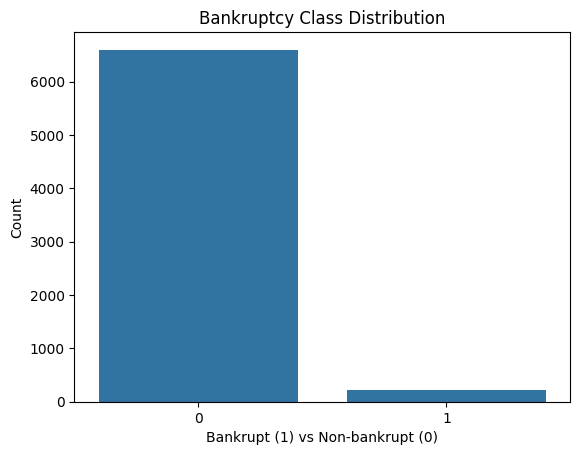

In [ ]:
sns.countplot(x=y)
plt.title("Bankruptcy Class Distribution")
plt.xlabel("Bankrupt (1) vs Non-bankrupt (0)")
plt.ylabel("Count")

## Correlation Heatmap

In [ ]:
# plt.figure(figsize=(15,10))
# sns.heatmap(df_scaled.corr(method="spearman"),cmap="coolwarm",annot=False,center=0)
# plt.title("Correlation matrix")

In [ ]:
# df_scaled.corr(method="spearman")

# Splitting dataset into training and testing set

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(df,y,test_size=0.2)

# SMOTE (Synthetic minority oversampling technique)

In [ ]:
smote=SMOTE(random_state=42)

In [ ]:
x_res,y_res=smote.fit_resample(x_train,y_train)

In [ ]:
y_res.value_counts()

,count
Bankrupt?,
0,5278
1,5278


# Saving preprocessed data

In [ ]:
# joblib.dump((x_train,x_test,y_train,y_test),"new_data.pkl")
# joblib.dump((x_res,x_test,y_res,y_test),"smote_data.pkl")

['new_data.pkl']

In [47]:
x_train,x_test,y_train,y_test=joblib.load("/content/drive/MyDrive/new_data.pkl")
x_res,x_test,y_res,y_test=joblib.load("/content/drive/MyDrive/smote_data.pkl")

# Training Models

In [48]:
def report(model,y_test,y_pred,y_proba):
  if hasattr(model,'n_iter_'):
    print(model.n_iter_)
  print(classification_report(y_test,y_pred))
  print("Confusion Matrix:\n ",confusion_matrix(y_test,y_pred))
  print(f"ROC AUC Score: {roc_auc_score(y_test,y_proba):.2f}")
  print(f"PR AUC score: {average_precision_score(y_test,y_proba):.2f}")
  print(f"Accuracy_score: {accuracy_score(y_test,y_pred):.2f}")

In [49]:
def threshold_testing(y_proba):
  best_f1=0
  best_thresh=0
  f1_scores=[]
  thresholds=np.arange(0.0,1.01,0.01)
  for tr in thresholds:
    y_pred=(y_proba>=tr).astype(int)
    f1=f1_score(y_test,y_pred)
    f1_scores.append(f1)
    if f1>best_f1:
      best_f1=f1
      best_thresh=tr
  print(f"best_f1: {best_f1:.2f}")
  print(f"best_thresh: {best_thresh:.2f}")


## Logistic Regression

### trying different solvers with l2 and l1

In [ ]:
# (default) penalty- l2, solver-lbfgs, max_iter-100
log_reg=LogisticRegression(max_iter=5000) # solver=lbfgs, penalty=l2
log_reg.fit(x_res,y_res)
y_pred=log_reg.predict(x_test)
y_proba=log_reg.predict_proba(x_test)[:,1]
report(log_reg,y_test,y_pred,y_proba)
threshold_testing(y_proba)

[2900]
              precision    recall  f1-score   support

           0       0.99      0.88      0.94      1324
           1       0.18      0.82      0.29        40

    accuracy                           0.88      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.97      0.88      0.92      1364

Confusion Matrix:
  [[1171  153]
 [   7   33]]
ROC AUC Score: 0.93
PR AUC score: 0.30
Accuracy_score: 0.88
best_f1: 0.42
best_thresh: 0.81


In [ ]:
# solver="liblinear",penalty="l2"
log_reg=LogisticRegression(max_iter=5000,solver="liblinear")
log_reg.fit(x_res,y_res)
y_pred=log_reg.predict(x_test)
y_proba=log_reg.predict_proba(x_test)[:,1]
report(log_reg,y_test,y_pred,y_proba)
threshold_testing(y_proba)

[50]
              precision    recall  f1-score   support

           0       0.99      0.88      0.94      1324
           1       0.17      0.80      0.28        40

    accuracy                           0.88      1364
   macro avg       0.58      0.84      0.61      1364
weighted avg       0.97      0.88      0.92      1364

Confusion Matrix:
  [[1170  154]
 [   8   32]]
ROC AUC Score: 0.93
PR AUC score: 0.30
Accuracy_score: 0.88
best_f1: 0.41
best_thresh: 0.80


In [ ]:
# solver="saga",penalty="l1"
log_reg=LogisticRegression(max_iter=5000,solver="saga",penalty="l1")
log_reg.fit(x_res,y_res)
y_pred=log_reg.predict(x_test)
y_proba=log_reg.predict_proba(x_test)[:,1]
report(log_reg,y_test,y_pred,y_proba)
threshold_testing(y_proba)

[2770]
              precision    recall  f1-score   support

           0       0.99      0.88      0.94      1324
           1       0.17      0.80      0.28        40

    accuracy                           0.88      1364
   macro avg       0.58      0.84      0.61      1364
weighted avg       0.97      0.88      0.92      1364

Confusion Matrix:
  [[1171  153]
 [   8   32]]
ROC AUC Score: 0.93
PR AUC score: 0.30
Accuracy_score: 0.88
best_f1: 0.42
best_thresh: 0.81


In [ ]:
# solver="liblinear",penalty="l1"
log_reg=LogisticRegression(max_iter=5000,solver="liblinear",penalty="l1")
log_reg.fit(x_res,y_res)
y_pred=log_reg.predict(x_test)
y_proba=log_reg.predict_proba(x_test)[:,1]
report(log_reg,y_test,y_pred,y_proba)
threshold_testing(y_proba)

[30]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1324
           1       0.18      0.78      0.29        40

    accuracy                           0.89      1364
   macro avg       0.58      0.83      0.61      1364
weighted avg       0.97      0.89      0.92      1364

Confusion Matrix:
  [[1179  145]
 [   9   31]]
ROC AUC Score: 0.93
PR AUC score: 0.31
Accuracy_score: 0.89
best_f1: 0.38
best_thresh: 0.86


### Regularization

In [ ]:
for c in [0.01,0.1,1,5,10]:
  log_reg=LogisticRegression(max_iter=6000,solver="liblinear",penalty="l2",C=c)
  log_reg.fit(x_res,y_res)
  y_pred=log_reg.predict(x_test)
  y_proba=log_reg.predict_proba(x_test)[:,1]
  threshold_testing(y_proba)

best_f1: 0.30
best_thresh: 0.64
best_f1: 0.37
best_thresh: 0.72
best_f1: 0.41
best_thresh: 0.80
best_f1: 0.39
best_thresh: 0.78
best_f1: 0.40
best_thresh: 0.77


In [ ]:
for c in [0.5,1,1.5,2,2.5,3]:
  log_reg=LogisticRegression(max_iter=6000,solver="liblinear",penalty="l2",C=c)
  log_reg.fit(x_res,y_res)
  y_pred=log_reg.predict(x_test)
  y_proba=log_reg.predict_proba(x_test)[:,1]
  threshold_testing(y_proba)

best_f1: 0.41
best_thresh: 0.77
best_f1: 0.41
best_thresh: 0.80
best_f1: 0.42
best_thresh: 0.81
best_f1: 0.41
best_thresh: 0.81
best_f1: 0.41
best_thresh: 0.82
best_f1: 0.40
best_thresh: 0.82


`best regularization strength= 1.5`

In [ ]:
log_reg=LogisticRegression(max_iter=6000,solver="liblinear",penalty="l2",C=1.5)
log_reg.fit(x_res,y_res)
y_pred=log_reg.predict(x_test)
y_proba=log_reg.predict_proba(x_test)[:,1]
report(log_reg,y_test,y_pred,y_proba)
threshold_testing(y_proba)

[82]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1324
           1       0.17      0.78      0.28        40

    accuracy                           0.88      1364
   macro avg       0.58      0.83      0.61      1364
weighted avg       0.97      0.88      0.92      1364

Confusion Matrix:
  [[1176  148]
 [   9   31]]
ROC AUC Score: 0.93
PR AUC score: 0.30
Accuracy_score: 0.88
best_f1: 0.42
best_thresh: 0.81


`but our precision and recall are lower than default one, thus we will stick with default solver=lbfgs, penalty=l2, C=1`

## Support Vector Machines

### Training on imbalanced dataset

In [ ]:
svm_clf=SVC(
    kernel="rbf", # linear,rbf,sigmoid,poly
    probability=True, # needed for predict_proba
    class_weight="balanced",
    C=1.0, # Regularization
    gamma="scale", # controls shape of decision boundary in non-linear kernels
)

svm_clf.fit(x_train,y_train)
y_pred=svm_clf.predict(x_test)
y_proba=svm_clf.predict_proba(x_test)[:,1]
report(svm_clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

[5027]
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      1324
           1       0.05      0.57      0.09        40

    accuracy                           0.66      1364
   macro avg       0.51      0.62      0.44      1364
weighted avg       0.95      0.66      0.77      1364

Confusion Matrix:
  [[872 452]
 [ 17  23]]
ROC AUC Score: 0.73
PR AUC score: 0.10
Accuracy_score: 0.66
best_f1: 0.17
best_thresh: 0.06


### Here SVM tries to draw a boundary that maximizes margin but with very few minority class samples it heavily favours majority class

### On balanced dataset (SMOTE)

In [ ]:
svm_clf=SVC(
    kernel="rbf",
    probability=True,
    C=1.0,
    gamma="scale",
)
svm_clf.fit(x_res,y_res)
y_pred=svm_clf.predict(x_test)
y_proba=svm_clf.predict_proba(x_test)[:,1]
report(svm_clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

[4835]
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      1324
           1       0.06      0.50      0.11        40

    accuracy                           0.75      1364
   macro avg       0.52      0.63      0.48      1364
weighted avg       0.95      0.75      0.83      1364

Confusion Matrix:
  [[1006  318]
 [  20   20]]
ROC AUC Score: 0.71
PR AUC score: 0.06
Accuracy_score: 0.75
best_f1: 0.13
best_thresh: 0.83


### Here balanced dataset performed better but after threshold optimizing imbalanced dataset has better score, but we would focus on balanced dataset bcz it gives a more balanced decision boundary and also helpful for recall

### GridSearchCV

In [50]:
params={
    "C":[0.1,0.5,1,2],
    "kernel":["rbf"],
    "gamma":["scale"] # controls influence of points
}
svm_clf=SVC(probability=True,class_weight="balanced",random_state=42)

In [ ]:
grid=GridSearchCV(svm_clf,params,cv=5,n_jobs=-1,scoring="f1",
                  verbose=0,return_train_score=False)

grid.fit(x_train,y_train)
clf=grid.best_estimator_
print(clf,grid.best_params_,grid.best_score_)
y_pred=clf.predict(x_test)
y_proba=clf.predict_proba(x_test)[:,1]
report(clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

SVC(C=1, class_weight='balanced', probability=True, random_state=42) {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} 0.09639258444479133
[5027]
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      1324
           1       0.05      0.57      0.09        40

    accuracy                           0.66      1364
   macro avg       0.51      0.62      0.44      1364
weighted avg       0.95      0.66      0.77      1364

Confusion Matrix:
  [[872 452]
 [ 17  23]]
ROC AUC Score: 0.73
PR AUC score: 0.10
Accuracy_score: 0.66
best_f1: 0.16
best_thresh: 0.07


## Decision Tree

In [ ]:
dec_clf=DecisionTreeClassifier(max_depth=None)
dec_clf.fit(x_res,y_res)
y_pred=dec_clf.predict(x_test)
y_proba=dec_clf.predict_proba(x_test)[:,1]
report(dec_clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1324
           1       0.23      0.45      0.31        40

    accuracy                           0.94      1364
   macro avg       0.61      0.70      0.64      1364
weighted avg       0.96      0.94      0.95      1364

Confusion Matrix:
  [[1264   60]
 [  22   18]]
ROC AUC Score: 0.70
PR AUC score: 0.12
Accuracy_score: 0.94
best_f1: 0.31
best_thresh: 0.01


In [ ]:
results=[]
for depth in [3,5,6,7,10]:
  dec_clf=DecisionTreeClassifier(max_depth=depth)
  dec_clf.fit(x_res,y_res)
  y_pred=dec_clf.predict(x_test)
  y_proba=dec_clf.predict_proba(x_test)[:,1]
  threshold_testing(y_proba)

best_f1: 0.35
best_thresh: 0.82
best_f1: 0.36
best_thresh: 0.94
best_f1: 0.38
best_thresh: 0.94
best_f1: 0.36
best_thresh: 0.96
best_f1: 0.34
best_thresh: 0.51


#### We can tune more hyperparameters for decision tree like min_samples_leaf, min_samples_split, max_features, criterion but randomforestclassifier generally performs well than a single decision tree

## RandomForestClassifier

In [ ]:
rnd_clf=RandomForestClassifier(
    n_estimators=150,
    max_depth=8,
)
rnd_clf.fit(x_res,y_res)
y_pred=rnd_clf.predict(x_test)
y_proba=rnd_clf.predict_proba(x_test)[:,1]
report(rnd_clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1324
           1       0.26      0.75      0.38        40

    accuracy                           0.93      1364
   macro avg       0.63      0.84      0.67      1364
weighted avg       0.97      0.93      0.95      1364

Confusion Matrix:
  [[1238   86]
 [  10   30]]
ROC AUC Score: 0.94
PR AUC score: 0.42
Accuracy_score: 0.93
best_f1: 0.48
best_thresh: 0.81


### GridSearchCV

#### MY MISTAKE HERE- Since SMOTE is applied before and use cross-validation in GridSearch, we would train on synthetic data which is easier and does not represent real world performance

In [ ]:
params={
    "max_depth":[6,8,10],
    "max_features":["sqrt","log2"],
    "n_estimators":[100,150,200],
    "bootstrap":[True],
}
rnd_clf=RandomForestClassifier(class_weight="balanced")

In [ ]:
grid=GridSearchCV(rnd_clf,params,cv=5,n_jobs=-1,scoring="f1",verbose=0,return_train_score=False)
grid.fit(x_train,y_train)
clf=grid.best_estimator_
print(clf,grid.best_params_,grid.best_score_)
y_pred=clf.predict(x_test)
y_proba=clf.predict_proba(x_test)[:,1]
report(clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=200) {'bootstrap': True, 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200} 0.45296116104545064
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1324
           1       0.28      0.72      0.40        40

    accuracy                           0.94      1364
   macro avg       0.64      0.83      0.68      1364
weighted avg       0.97      0.94      0.95      1364

Confusion Matrix:
  [[1249   75]
 [  11   29]]
ROC AUC Score: 0.94
PR AUC score: 0.45
Accuracy_score: 0.94
best_f1: 0.56
best_thresh: 0.75


### Again with wider parameter space

In [ ]:
params={
    "max_depth":[6,8,10],
    "max_features":["sqrt","log2"],
    "n_estimators":[150,200],
    "bootstrap":[True],
    "min_samples_split":[10,20,40],
    "min_samples_leaf":[5,10,15]
}
rnd_clf=RandomForestClassifier(class_weight="balanced",random_state=42)

In [ ]:
grid=GridSearchCV(rnd_clf,params,cv=5,n_jobs=-1,scoring="f1",verbose=0,return_train_score=False)
grid.fit(x_train,y_train)
clf=grid.best_estimator_
print(grid.best_params_,"best_score: ",grid.best_score_)
y_pred=clf.predict(x_test)
y_proba=clf.predict_proba(x_test)[:,1]
report(clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

{'bootstrap': True, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 150} best_score:  0.47698939254993045
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1324
           1       0.32      0.68      0.44        40

    accuracy                           0.95      1364
   macro avg       0.66      0.82      0.70      1364
weighted avg       0.97      0.95      0.96      1364

Confusion Matrix:
  [[1267   57]
 [  13   27]]
ROC AUC Score: 0.94
PR AUC score: 0.46
Accuracy_score: 0.95
best_f1: 0.54
best_thresh: 0.66


### Again with slightly different parameter space as this time results were lower but we have used min_samples_split and min_samples_leaf

In [ ]:
params={
    "max_depth":[8],
    "max_features":["sqrt","log2"],
    "n_estimators":[150,200],
    "bootstrap":[True],
    "min_samples_split":[15,20,25,30],
    "min_samples_leaf":[7,10,13]
}
rnd_clf=RandomForestClassifier(class_weight="balanced")

In [ ]:
grid=GridSearchCV(rnd_clf,params,cv=5,n_jobs=-1,scoring="f1",verbose=0,return_train_score=False)
grid.fit(x_train,y_train)
clf=grid.best_estimator_
print(grid.best_params_,"best_score: ",grid.best_score_)
y_pred=clf.predict(x_test)
y_proba=clf.predict_proba(x_test)[:,1]
report(clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 150} best_score:  0.47231912072470117
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1324
           1       0.32      0.68      0.44        40

    accuracy                           0.95      1364
   macro avg       0.66      0.82      0.70      1364
weighted avg       0.97      0.95      0.96      1364

Confusion Matrix:
  [[1267   57]
 [  13   27]]
ROC AUC Score: 0.94
PR AUC score: 0.49
Accuracy_score: 0.95
best_f1: 0.52
best_thresh: 0.66


`Extracting top features from our best RandomForest model based on`  
`1) top 30 and 2) features which contribute 95% of whole`

In [ ]:
importances=pd.Series(clf.feature_importances_,index=x_train.columns)
top30_features=importances.sort_values(ascending=False).head(30)
top_features_count=(importances.sort_values(ascending=False).cumsum()>=0.95).sum()
top_features=importances.sort_values(ascending=False).head(top_features_count)
top30_features,top_features_count,top_features

(Continuous interest rate (after tax)                       0.043508
 Retained Earnings to Total Assets                          0.039983
 Equity to Liability                                        0.039004
 Persistent EPS in the Last Four Seasons                    0.035431
 ROA(B) before interest and depreciation after tax          0.035275
 Total debt/Total net worth                                 0.033153
 Net profit before tax/Paid-in capital                      0.032211
 Per Share Net profit before tax (Yuan ¥)                   0.032055
 Interest Expense Ratio                                     0.028599
 Quick Ratio                                                0.027853
 Degree of Financial Leverage (DFL)                         0.027372
 Net Income to Total Assets                                 0.026946
 ROA(C) before interest and depreciation before interest    0.025781
 Non-industry income and expenditure/revenue                0.025700
 Total income/Total expense       

In [ ]:
xtop_train=x_train[top_features.index]
xtop_test=x_test[top_features.index]
xtop30_train=x_train[top30_features.index]
xtop30_test=x_test[top30_features.index]

<Axes: >

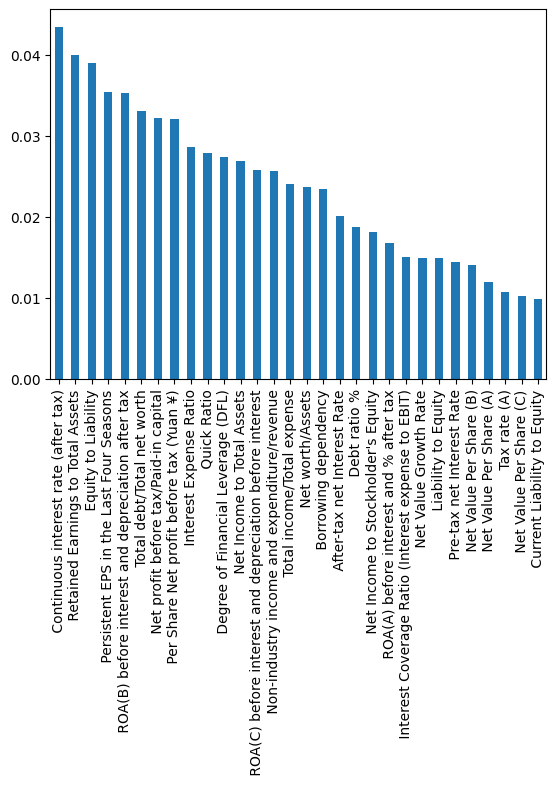

In [ ]:
# plotting top 30 features with their importance levels
top30_features.plot(kind="bar")

<Axes: >

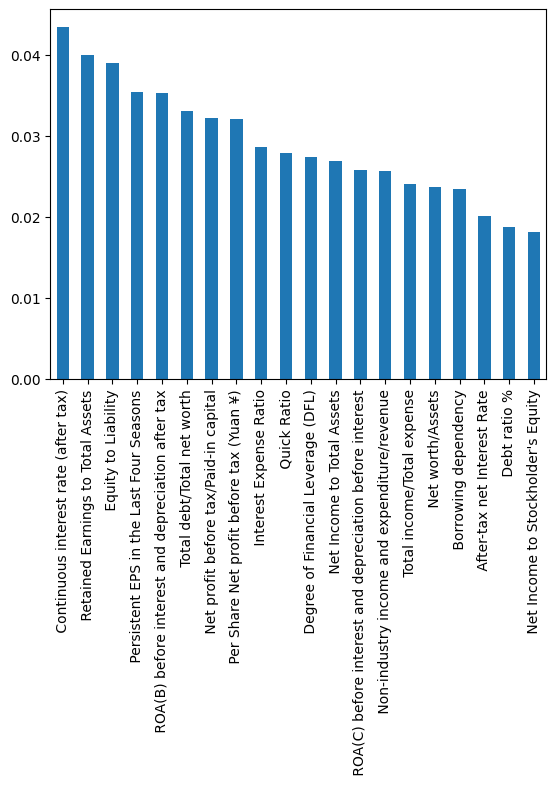

In [ ]:
# plotting top features with cumulative sum of their importance levels greater than 0.95
top_features.plot(kind="bar")

## XGBoostClassifier

#### training on imbalanced dataset(No SMOTE) using scale_pos_weight

In [ ]:
x_boost,x_val,y_boost,y_val=train_test_split(x_train,y_train,test_size=0.15)
y_boost.value_counts()
scale_pos_weight=y_boost.value_counts()[0]/y_boost.value_counts()[1]

In [ ]:
xgb=XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    early_stopping_rounds=30
)

#### Unfortunately, XGBoost does not support f1 as a built in eval_metric bcz it is not continous, differentiable function, which makes it hard to optimize during boosting
logloss-default,
auc-good overall measure,
aucpr-better for imbalanced datasets,
error-classification error rate

In [ ]:
xgb.fit(
    x_boost,y_boost,
    eval_set=[(x_val,y_val)], #should be a tuple inside a list
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

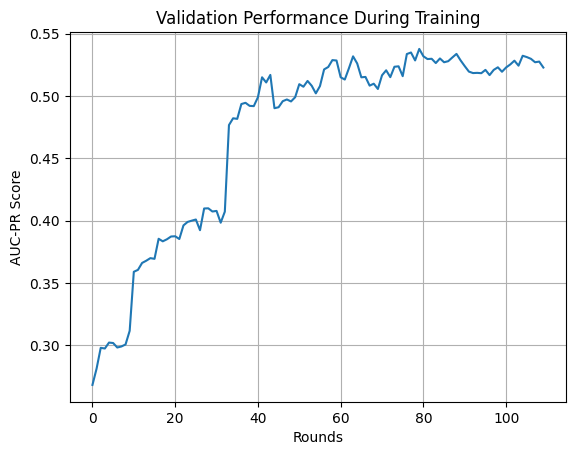

In [ ]:
plt.plot(xgb.evals_result()['validation_0']['aucpr'])
plt.xlabel('Rounds')
plt.ylabel('AUC-PR Score')
plt.title('Validation Performance During Training')
plt.grid(True)

In [ ]:
xgb.best_iteration,xgb.best_score

(79, 0.5376405715652071)

In [ ]:
y_pred=xgb.predict(x_test)
y_proba=xgb.predict_proba(x_test)[:,1]
report(xgb,y_test,y_pred,y_proba)
threshold_testing(y_proba)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1324
           1       0.27      0.70      0.39        40

    accuracy                           0.94      1364
   macro avg       0.63      0.82      0.68      1364
weighted avg       0.97      0.94      0.95      1364

Confusion Matrix:
  [[1249   75]
 [  12   28]]
ROC AUC Score: 0.91
PR AUC score: 0.39
Accuracy_score: 0.94
best_f1: 0.45
best_thresh: 0.81


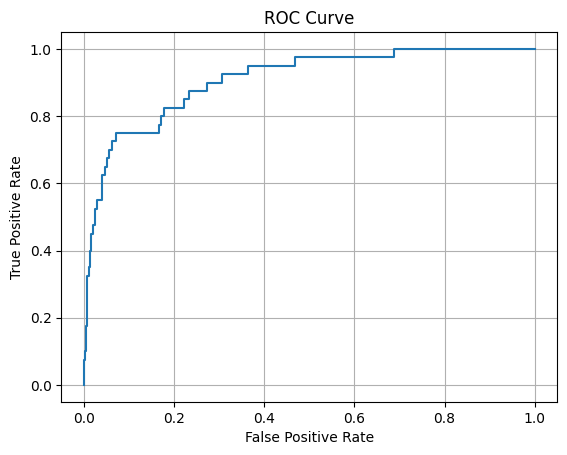

In [ ]:
fpr,tpr,_=roc_curve(y_test,y_proba)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)

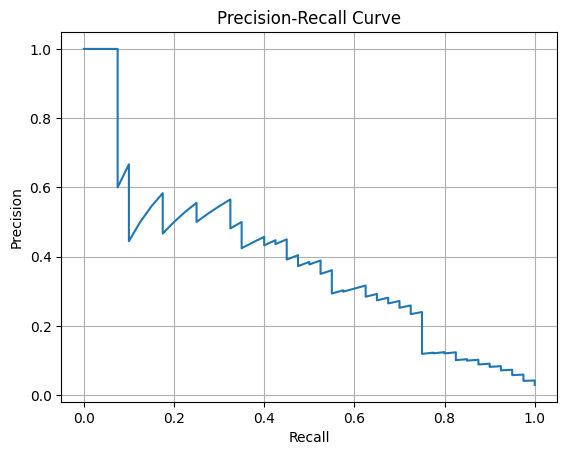

In [ ]:
precision,recall,_=precision_recall_curve(y_test,y_proba)
plt.plot(recall,precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)

### GridSearchCV

#### We can not use early-stopping with GridSearchCV

In [ ]:
scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]

In [ ]:
params={
    'n_estimators':[300],
    'max_depth':[3,5,7],
    'gamma':[0,0.1,0.3],
    'learning_rate':[0.01,0.05,0.1],
    'min_child_weight':[1,5,10]
}
xgb=XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    # use_label_encoder=False
)

In [ ]:
# eval_metric="aucpr" is just for monitoring training progress, not model selection
# scoring="f1" decides which model is best in GridSearchCV
grid=GridSearchCV(
    xgb,params,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=True
)
grid.fit(x_train,y_train)
clf=grid.best_estimator_
print(grid.best_params_,grid.best_score_)
y_pred=clf.predict(x_test)
y_proba=clf.predict_proba(x_test)[:,1]
report(clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300} 0.5162880680871685
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1324
           1       0.45      0.53      0.48        40

    accuracy                           0.97      1364
   macro avg       0.72      0.75      0.73      1364
weighted avg       0.97      0.97      0.97      1364

Confusion Matrix:
  [[1298   26]
 [  19   21]]
ROC AUC Score: 0.93
PR AUC score: 0.44
Accuracy_score: 0.97
best_f1: 0.54
best_thresh: 0.40


### Again GridSearch

In [ ]:
params={
    'n_estimators':[300],
    'max_depth':[5,6],
    'learning_rate':[0.1,0.125,0.15],
    'subsample':[0.9,1],
    'colsample_bytree':[0.8,0.9],
    'min_child_weight':[5,7,9]
}
xgb=XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    # use_label_encoder=False
)

In [ ]:
grid=GridSearchCV(
    xgb,params,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=True
)
grid.fit(x_train,y_train)
clf=grid.best_estimator_
print(grid.best_params_,grid.best_score_)
y_pred=clf.predict(x_test)
y_proba=clf.predict_proba(x_test)[:,1]
report(clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 300, 'subsample': 1} 0.525251046618224
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1324
           1       0.46      0.55      0.50        40

    accuracy                           0.97      1364
   macro avg       0.72      0.77      0.74      1364
weighted avg       0.97      0.97      0.97      1364

Confusion Matrix:
  [[1298   26]
 [  18   22]]
ROC AUC Score: 0.93
PR AUC score: 0.41
Accuracy_score: 0.97
best_f1: 0.53
best_thresh: 0.40


#### this time best_f1 after threshold optimization and PR AUC score are lower than previous one 0.54 so We will choose best model from previous grid search

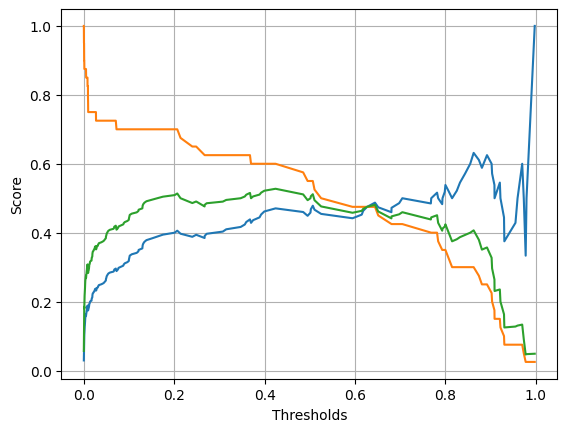

In [ ]:
precision,recall,thresholds=precision_recall_curve(y_test,y_proba)
f1_scores=[]
for t in thresholds:
    y_pred=(y_proba>=t).astype(int)
    f1=f1_score(y_test,y_pred)
    f1_scores.append(f1)
plt.plot(thresholds,precision[:-1],label="Precision")
plt.plot(thresholds,recall[:-1],label="Recall")
plt.plot(thresholds,f1_scores,label="f1_score")
plt.xlabel("Thresholds")
plt.ylabel("Score")
plt.grid(True)

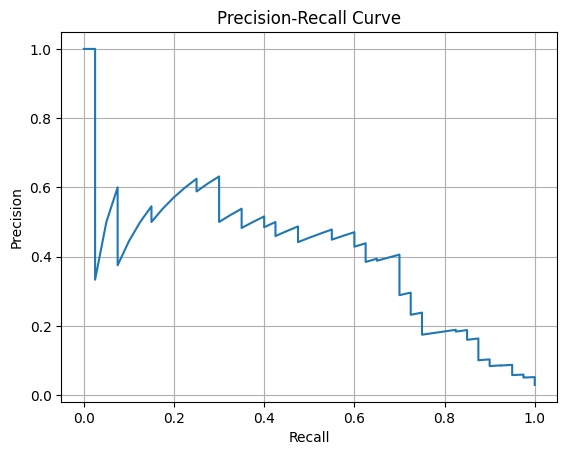

In [ ]:
plt.plot(recall,precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)

In [ ]:
joblib.dump(clf,"/kaggle/working/xgboost_bestmodel.pkl")
# best_thresh: 0.40

['/kaggle/working/xgboost_bestmodel.pkl']

In [ ]:
best=XGBClassifier(
    n_estimators= 300,
    gamma= 0,
    learning_rate= 0.1,
    max_depth= 5,
    min_child_weight= 5,
    scale_pos_weight=scale_pos_weight
)

#### With top 20 features performance of best XGBoost model go down

In [ ]:
best.fit(xtop_train,y_train)
y_pred=best.predict(xtop_test)
y_proba=best.predict_proba(xtop_test)[:,1]
report(best,y_test,y_pred,y_proba)
threshold_testing(y_proba)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1324
           1       0.39      0.45      0.42        40

    accuracy                           0.96      1364
   macro avg       0.69      0.71      0.70      1364
weighted avg       0.97      0.96      0.96      1364

Confusion Matrix:
  [[1296   28]
 [  22   18]]
ROC AUC Score: 0.92
PR AUC score: 0.33
Accuracy_score: 0.96
best_f1: 0.46
best_thresh: 0.63


#### With top 30 features performance of best XGBoost model is also lower

In [ ]:
best.fit(xtop30_train,y_train)
y_pred=best.predict(xtop30_test)
y_proba=best.predict_proba(xtop30_test)[:,1]
report(best,y_test,y_pred,y_proba)
threshold_testing(y_proba)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1324
           1       0.44      0.53      0.48        40

    accuracy                           0.97      1364
   macro avg       0.71      0.75      0.73      1364
weighted avg       0.97      0.97      0.97      1364

Confusion Matrix:
  [[1297   27]
 [  19   21]]
ROC AUC Score: 0.94
PR AUC score: 0.37
Accuracy_score: 0.97
best_f1: 0.49
best_thresh: 0.37


## Ensemble Methods

### Voting Classifier

` i have tried first hard voting which is very very bad so we will only use voting=soft for prediction based on probabilities`

`i included first best decision tree along with logistic,randomforest,xgboost but it worsens result`

In [ ]:
log=LogisticRegression(max_iter=6000,solver="lbfgs",penalty="l2",C=1)
dec=DecisionTreeClassifier(max_depth=6)
rnd=RandomForestClassifier(n_estimators=150,max_features="log2",max_depth=8,bootstrap=True)
xgb=XGBClassifier(n_estimators= 300,gamma= 0, learning_rate= 0.1,max_depth= 5,min_child_weight= 5,scale_pos_weight=scale_pos_weight)

In [ ]:
voting_clf=VotingClassifier(
    estimators=[
        ("lr",log),
        ("rnd",rnd),
        ("xgb",xgb)
    ],
    voting="soft"
)
voting_clf.fit(x_train,y_train)
y_pred=voting_clf.predict(x_test)
y_proba=voting_clf.predict_proba(x_test)[:,1]
report(voting_clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1324
           1       0.50      0.15      0.23        40

    accuracy                           0.97      1364
   macro avg       0.74      0.57      0.61      1364
weighted avg       0.96      0.97      0.96      1364

Confusion Matrix:
  [[1318    6]
 [  34    6]]
ROC AUC Score: 0.93
PR AUC score: 0.40
Accuracy_score: 0.97
best_f1: 0.52
best_thresh: 0.26


### Stacking Classifier (Stacked generalization)